In [1]:
import dgl
from sklearn.neighbors import kneighbors_graph
import numpy as np
import pandas as pd
import torch

Using backend: pytorch


Exception: Detected an old version of PyTorch. Please update torch>=1.5.0 for the best experience.

In [2]:
df = pd.read_csv('../data/CRC_master.csv')

In [122]:
df.shape

(258385, 83)

In [123]:
df['ClusterName'].unique()

array(['granulocytes', 'vasculature', 'CD4+ T cells CD45RO+',
       'tumor cells', 'stroma', 'CD68+CD163+ macrophages', 'adipocytes',
       'plasma cells', 'CD8+ T cells', 'dirt', 'Tregs', 'CD4+ T cells',
       'CD11c+ DCs', 'B cells', 'CD11b+CD68+ macrophages',
       'smooth muscle', 'undefined', 'tumor cells / immune cells',
       'immune cells / vasculature', 'immune cells', 'NK cells', 'nerves',
       'CD68+ macrophages GzmB+', 'CD68+ macrophages', 'lymphatics',
       'CD11b+ monocytes', 'CD4+ T cells GATA3+', 'CD163+ macrophages',
       'CD3+ T cells'], dtype=object)

In [3]:
df.head()

,Unnamed: 0,CellID,patients,spots,groups,ClusterName,size,CD44 - stroma,FOXP3 - regulatory T cells,CD8 - cytotoxic T cells,...,CD68+PD-1+,CD8+ICOS+,CD8+Ki67+,CD8+PD-1+,Treg-ICOS+,Treg-Ki67+,Treg-PD-1+,X,Y,Z
0,0,0,1,1_A,1,granulocytes,10120,1.843591,17.398706,0.000000,...,0,0,0,0,0,0,0,77,589,10
1,1,1,1,1_A,1,granulocytes,861,30.284525,18.375738,74.695236,...,0,0,0,0,0,0,0,106,826,10
2,2,2,1,1_A,1,granulocytes,6206,139.488510,249.746979,85.556976,...,0,0,0,0,0,0,0,107,545,10
3,3,3,1,1_A,1,granulocytes,6320,20.596886,81.759758,0.000000,...,0,0,0,0,0,0,0,98,564,10
4,4,4,1,1_A,1,granulocytes,1591,67.328728,122.195473,11.028284,...,0,0,0,0,0,0,0,217,329,10


In [4]:
subset = df.loc[df.loc[:,'spots'] == '1_A',:]

In [5]:
features = subset.loc[:,'size':'Treg-PD-1+'].to_numpy()

In [7]:
centroids = subset.loc[:,'X':'Y'].to_numpy()

In [8]:
centroids

array([[  77,  589],
       [ 106,  826],
       [ 107,  545],
       ...,
       [1310,  135],
       [1634, 1242],
       [1674, 1096]])

In [19]:
df['spots'].unique()

array(['1_A', '1_B', '2_A', '2_B', '3_A', '3_B', '4_A', '4_B', '5_A',
       '5_B', '6_A', '6_B', '7_A', '7_B', '8_A', '8_B', '9_A', '9_B',
       '10_A', '10_B', '11_A', '11_B', '12_A', '12_B', '13_A', '13_B',
       '14_A', '14_B', '15_A', '15_B', '16_A', '16_B', '17_A', '17_B',
       '18_A', '18_B', '19_A', '19_B', '20_A', '20_B', '21_A', '21_B',
       '22_A', '22_B', '23_A', '23_B', '24_A', '24_B', '25_A', '25_B',
       '26_A', '26_B', '27_A', '27_B', '28_A', '28_B', '29_A', '29_B',
       '30_A', '30_B', '31_A', '31_B', '32_A', '32_B', '33_A', '33_B',
       '34_A', '34_B', '35_A', '35_B', '36_A', '36_B', '37_A', '37_B',
       '38_A', '38_B', '39_A', '39_B', '40_A', '40_B', '41_A', '41_B',
       '42_A', '42_B', '43_A', '43_B', '44_A', '44_B', '45_A', '45_B',
       '46_A', '46_B', '47_A', '47_B', '48_A', '48_B', '49_A', '49_B',
       '50_A', '50_B', '51_A', '51_B', '52_A', '52_B', '53_A', '53_B',
       '54_A', '54_B', '55_A', '55_B', '56_A', '56_B', '57_A', '57_B',
       '

In [21]:
subset['patients'].unique()[0]

1

In [44]:
pt_data = pd.read_excel('../data/CRC_TMAs_patient_annotations.xlsx')
num_pts = 35

/home/joeleliason/anaconda3/envs/hactnet/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [27]:
pt_data.columns

Index(['Patient', 'Group', 'TMA spot / region', 'LA', 'Diffuse', 'LA.1',
       'Diffuse.1', 'Klintrup_Makinen', 'CLR_Graham_Appelman', 'Sex', 'Age',
       'Full_Histology', 'Full_Tumor_Location', 'Simple_Tumor_Location',
       'PreOP_Therapy', 'PostOP_Therapy', 'pT', 'pN', 'pM', 'p_TNM', 'cM',
       'cp_TNM_Simple', 'G', 'L', 'V', 'OS', 'OS_Censor', 'DFS', 'DFS_Censor',
       'Nbr_Buds_ITBCC', 'Budding grade', 'MLH1', 'PMS2', 'MSH6', 'MSH2',
       'MSI_IHC', 'MSI_PCR'],
      dtype='object')

In [43]:
pt_data.loc[:,'cp_TNM_Simple']

0     3.0
1     3.0
2     3.0
3     3.0
4     3.0
5     3.0
6     3.0
7     4.0
8     3.0
9     3.0
10    3.0
11    3.0
12    3.0
13    4.0
14    4.0
15    3.0
16    3.0
17    4.0
18    3.0
19    4.0
20    3.0
21    3.0
22    3.0
23    3.0
24    3.0
25    3.0
26    3.0
27    3.0
28    3.0
29    3.0
30    3.0
31    4.0
32    4.0
33    4.0
34    3.0
35    NaN
36    NaN
37    NaN
38    NaN
39    NaN
40    NaN
41    NaN
42    NaN
43    NaN
44    NaN
Name: cp_TNM_Simple, dtype: float64

In [22]:
k = 5
thresh = 50
LABEL = "label"
CENTROID = "centroid"
FEATURES = "feat"
graphs = []
patients = []
for spot in df['spots'].unique():
    subset = df.loc[df.loc[:,'spots'] == spot,:]
    features = subset.loc[:,'size':'Treg-PD-1+'].to_numpy() # np.ndarray, shape(n_nodes,n_feats)
    centroids = subset.loc[:,'X':'Y'].to_numpy() # np.ndarray, shape(n_nodes,2)
    _,annotation = np.unique(subset.loc[:,'ClusterName'].to_numpy(), return_inverse=True) # np.ndarray, shape(n_nodes,)
    num_nodes = features.shape[0]
    graph = dgl.DGLGraph()
    graph.add_nodes(num_nodes)

    # add image size as graph data
    # image_size = (instance_map.shape[1], instance_map.shape[0])  # (x, y)

    # get instance centroids
    # centroids = self._get_node_centroids(instance_map)

    # add node content
    # self._set_node_centroids(centroids, graph)
    graph.ndata[CENTROID] = torch.FloatTensor(centroids)
    # self._set_node_features(features, image_size, graph)
    graph.ndata[FEATURES] = torch.FloatTensor(features)
    if annotation is not None:
        graph.ndata[LABEL] = torch.FloatTensor(annotation.astype(float))
    # build kNN adjacency
    adj = kneighbors_graph(
        centroids,
        k,
        mode="distance",
        include_self=False,
        metric="euclidean").toarray()

    # filter edges that are too far (ie larger than thresh)
    if thresh is not None:
        adj[adj > thresh] = 0

    edge_list = np.nonzero(adj)
    graph.add_edges(list(edge_list[0]), list(edge_list[1]))
    graphs.append(graph)
    patients.append(subset['patients'].unique()[0])

In [49]:
targets = []
for pt in patients:
    cp = pt_data.loc[pt_data.loc[:,'Patient'] == pt,'cp_TNM_Simple'].values[0]
    t = 0 if cp == 3.0 else 1
    targets.append(t)

In [53]:
data = list(zip(graphs,targets))

In [55]:
data[0]

(DGLGraph(num_nodes=1164, num_edges=4376,
          ndata_schemes={'centroid': Scheme(shape=(2,), dtype=torch.float32), 'feat': Scheme(shape=(74,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.float32)}
          edata_schemes={}),
 0)

In [56]:
def print_graph_properties(g):
    print('Graph has the following properties:')
    print('- {} nodes'.format(g.number_of_nodes()))
    for key, val in g.ndata.items():
        print('- "{}" with {} node features'.format(key, list(val.shape)))
    print('- {} edges'.format(g.number_of_edges()))

In [59]:
import pickle
with open('../data/graphs_labels.pkl','wb') as f:
    pickle.dump(data,f)

In [57]:
from torch.utils.data import DataLoader
import random 

# 1. load the data: graphs and labels 
# data = dgl.data.GINDataset('MUTAG', self_loop=False)

# 2. Inspect manually the data by printing one of the samples
g, label = data[0]
print_graph_properties(g)

# 3. Batchify and train/val split the data
random.shuffle(data)
train_data = data[:int(len(data)* 0.7)]
val_data = data[int(len(data)*0.7):]
batch_size = 8

def collate(batch):
    g = dgl.batch([example[0] for example in batch])
    l = torch.LongTensor([example[1] for example in batch])
    return g, l

train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate)
val_dataloader = DataLoader(train_data, batch_size, collate_fn=collate)

Graph has the following properties:
- 1164 nodes
- "centroid" with [1164, 2] node features
- "feat" with [1164, 74] node features
- "label" with [1164] node features
- 4376 edges


In [58]:
train_dataloader

In [72]:
gnn_params = {
    'readout_op': 'concat',
    'layer_type': 'gin_layer',
    'output_dim': 32,
    'num_layers': 2,
    'readout_type': 'mean'
}
classification_params = {
    'hidden_dim': 20,
    'num_layers': 2
}

In [73]:
from histocartography.ml import CellGraphModel

In [74]:
node_dim = features.shape[1]

In [83]:
cgm = CellGraphModel(gnn_params,classification_params,node_dim,num_classes = 2)

In [84]:
import torch
from tqdm import trange

# build optimizer
optimizer = torch.optim.Adam(
    cgm.parameters(),
    lr=10e-3,
    weight_decay=5e-4
)

# define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# training 
val_loss = 10e5
val_accuracy = 0.

In [85]:
with trange(50) as t:
    for epoch in t:
        t.set_description('Validation with loss={} | accuracy={}'.format(val_loss, val_accuracy))
        # A.) train for 1 epoch 
        cgm.train()
        for graphs, labels in train_dataloader:

            # 1. forward pass
            labels = labels
            logits = cgm(graphs)

            # 2. backward pass
            loss = loss_fn(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        cgm.eval()
        all_val_logits = []
        all_val_labels = []
        for graphs, labels in val_dataloader:
            with torch.no_grad():
                labels = labels
                logits = cgm(graphs)
            all_val_logits.append(logits)
            all_val_labels.append(labels)

        all_val_logits = torch.cat(all_val_logits).cpu()
        all_val_labels = torch.cat(all_val_labels).cpu()

        with torch.no_grad():
            val_loss = round(loss_fn(all_val_logits, all_val_labels).item(), 2)
            _, predictions = torch.max(all_val_logits, dim=1)
            correct = torch.sum(predictions.to(int) == all_val_labels.to(int))
            val_accuracy = round(correct.item() * 1.0 / len(all_val_labels), 2)

Validation with loss=0.16 | accuracy=0.95: 100%|█| 50/50 [03:08<00:00,  3.76s/it


In [86]:
correct

tensor(92)

In [88]:
predictions == all_val_labels

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True])

In [89]:
len(predictions)

98

In [92]:
len(train_data)

98

In [93]:
from histocartography.interpretability import GraphGradCAMExplainer

explainer = GraphGradCAMExplainer(model=cgm)

In [94]:
graph = data[0][0]
importance_scores, _ = explainer.process(graph)

In [95]:
graph

DGLGraph(num_nodes=2800, num_edges=13723,
         ndata_schemes={'centroid': Scheme(shape=(2,), dtype=torch.float32), 'feat': Scheme(shape=(74,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.float32)}
         edata_schemes={})

In [96]:
importance_scores

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [97]:
sum(importance_scores)

0.0

In [98]:
explainer.extractor

GradCAM()

In [100]:
explainer.gnn_layer_ids

['0', '1']

In [101]:
original_logits = explainer.model(graph)

In [102]:
original_logits

tensor([[-0.3588,  0.6683]], grad_fn=<AddmmBackward>)

In [103]:
classes = [original_logits.argmax().item()]

In [104]:
classes

[1]

In [105]:
original_logits.argmax()

tensor(1)

In [108]:
node_importance = explainer.extractor(
    1, original_logits, normalized=True
).cpu()

RuntimeError: stack expects a non-empty TensorList

In [109]:
explainer.backward_hook

AttributeError: 'GraphGradCAMExplainer' object has no attribute 'backward_hook'

In [114]:
import torch
import torch.nn as nn
import dgl.function as fn
from dgl.nn import GATConv


class GAT(nn.Module):
    def __init__(self,
                 g,
                 num_layers,
                 in_dim,
                 num_hidden,
                 num_classes,
                 heads,
                 activation,
                 feat_drop,
                 attn_drop,
                 negative_slope,
                 residual):
        super(GAT, self).__init__()
        self.g = g
        self.num_layers = num_layers
        self.gat_layers = nn.ModuleList()
        self.activation = activation
        # input projection (no residual)
        self.gat_layers.append(GATConv(
            in_dim, num_hidden, heads[0],
            feat_drop, attn_drop, negative_slope, False, self.activation))
        # hidden layers
        for l in range(1, num_layers):
            # due to multi-head, the in_dim = num_hidden * num_heads
            self.gat_layers.append(GATConv(
                num_hidden * heads[l-1], num_hidden, heads[l],
                feat_drop, attn_drop, negative_slope, residual, self.activation))
        # output projection
        self.gat_layers.append(GATConv(
            num_hidden * heads[-2], num_classes, heads[-1],
            feat_drop, attn_drop, negative_slope, residual, None))

    def forward(self, inputs):
        h = inputs
        for l in range(self.num_layers):
            h = self.gat_layers[l](self.g, h).flatten(1)
        # output projection
        logits = self.gat_layers[-1](self.g, h).mean(1)
        return logits

In [ ]:
m = GAT(

In [110]:
# import matplotlib.pyplot as plt
# import networkx as nx

In [112]:
# G = dgl.to_networkx(graph)
# options = {
#     'node_color': 'black',
#     'node_size': 20,
#     'width': 1,
# }

KeyboardInterrupt: 

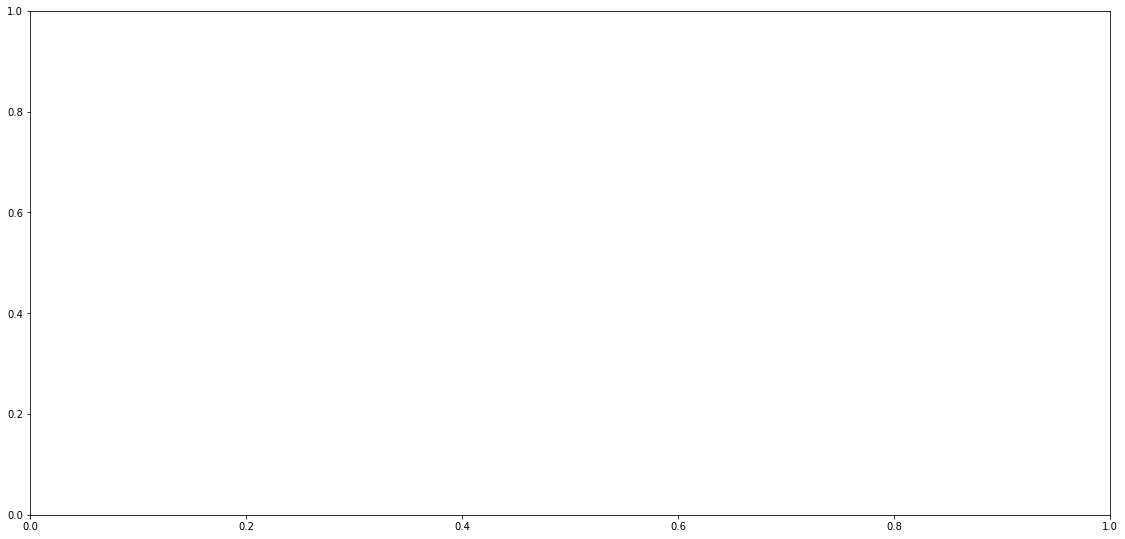

In [113]:
# plt.figure(figsize=[15,7])
# nx.draw(G, **options)

In [121]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from dgl.data import MiniGCDataset
from dgl.nn.pytorch import *
from torch.utils.data import DataLoader


class GATLayer(nn.Module):
    def __init__(self,
                 in_dim,
                 out_dim,
                 num_heads,
                 feat_drop=0.,
                 attn_drop=0.,
                 alpha=0.2,
                 agg_activation=F.elu):
        super(GATLayer, self).__init__()

        self.num_heads = num_heads
        self.feat_drop = nn.Dropout(feat_drop)
        self.fc = nn.Linear(in_dim, num_heads * out_dim, bias=False)
        self.attn_l = nn.Parameter(torch.Tensor(size=(num_heads, out_dim, 1)))
        self.attn_r = nn.Parameter(torch.Tensor(size=(num_heads, out_dim, 1)))
        self.attn_drop = nn.Dropout(attn_drop)
        self.activation = nn.LeakyReLU(alpha)
        self.softmax = edge_softmax

        self.agg_activation=agg_activation

    def clean_data(self):
        ndata_names = ['ft', 'a1', 'a2']
        edata_names = ['a_drop']
        for name in ndata_names:
            self.g.ndata.pop(name)
        for name in edata_names:
            self.g.edata.pop(name)

    def forward(self, feat, bg):
        # prepare, inputs are of shape V x F, V the number of nodes, F the dim of input features
        self.g = bg
        h = self.feat_drop(feat)
        # V x K x F', K number of heads, F' dim of transformed features
        ft = self.fc(h).reshape((h.shape[0], self.num_heads, -1))
        head_ft = ft.transpose(0, 1)                              # K x V x F'
        a1 = torch.bmm(head_ft, self.attn_l).transpose(0, 1)      # V x K x 1
        a2 = torch.bmm(head_ft, self.attn_r).transpose(0, 1)      # V x K x 1
        self.g.ndata.update({'ft' : ft, 'a1' : a1, 'a2' : a2})
        # 1. compute edge attention
        self.g.apply_edges(self.edge_attention)
        # 2. compute softmax in two parts: exp(x - max(x)) and sum(exp(x - max(x)))
        self.edge_softmax()
        # 2. compute the aggregated node features scaled by the dropped,
        # unnormalized attention values.
        self.g.update_all(fn.src_mul_edge('ft', 'a_drop', 'ft'), fn.sum('ft', 'ft'))
        # 3. apply normalizer
        ret = self.g.ndata['ft']                                  # V x K x F'
        ret = ret.flatten(1)

        if self.agg_activation is not None:
            ret = self.agg_activation(ret)

        # Clean ndata and edata
        self.clean_data()

        return ret

    def edge_attention(self, edges):
        # an edge UDF to compute un-normalized attention values from src and dst
        a = self.activation(edges.src['a1'] + edges.dst['a2'])
        return {'a' : a}

    def edge_softmax(self):
        attention = self.softmax(self.g, self.g.edata.pop('a'))
        # Dropout attention scores and save them
        self.g.edata['a_drop'] = self.attn_drop(attention)

class GATClassifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_heads, n_classes):
        super(GATClassifier, self).__init__()

        self.layers = nn.ModuleList([
            GATLayer(in_dim, hidden_dim, num_heads),
            GATLayer(hidden_dim * num_heads, hidden_dim, num_heads)
        ])
        self.classify = nn.Linear(hidden_dim * num_heads, n_classes)

    def forward(self, bg):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = bg.in_degrees().view(-1, 1).float()
        for i, gnn in enumerate(self.layers):
            h = gnn(h, bg)
        bg.ndata['h'] = h
        hg = dgl.mean_nodes(bg, 'h')
        return self.classify(hg)

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

ImportError: cannot import name 'convert_to_strmap' from 'dgl.container' (/home/joeleliason/anaconda3/envs/hactnet/lib/python3.7/site-packages/dgl/container.py)

In [ ]:
# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

# Create model
model = GATClassifier(1, 16, 8, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))